#Robert Miller
#I pledge my honor that I have abided by the Stevens Honor System

#EDA on Hitters.csv

In [1]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.optimize import Bounds, BFGS
from scipy.optimize import LinearConstraint, minimize
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as dt
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('Hitters.csv') #Process as in hw1

# for col in df.columns:
#   print(col) #
#   print(df[col].isnull().sum())
#Im not running this loop every time, but Salary is missing 59 values, which is not insignificant, but not most of the values, so instead of dropping the column I am going to replace the Nan with the average values
sal_avg = df['Salary'].mean()
df['Salary'] = df['Salary'].fillna(sal_avg)
X_train, X_test = train_test_split (df,test_size = 0.2, random_state = 42) #8 to 2 split

In [3]:
#remove the outliers in the data, this is done by my own discretion before normalization
X_train = X_train[X_train['HmRun'] < 35]
X_test = X_test[X_test['HmRun'] < 35]
X_train = X_train[X_train['RBI'] < 120]
X_test = X_test[X_test['RBI'] < 120]
X_train = X_train[X_train['Walks'] < 100]
X_test = X_test[X_test['Walks'] < 100]
X_train = X_train[X_train['Years'] < 20]
X_test = X_test[X_test['Years'] < 20]
X_train = X_train[X_train['CHmRun'] < 200]
X_test = X_test[X_test['CHmRun'] < 200]
X_train = X_train[X_train['CRuns'] < 1200]
X_test = X_test[X_test['CRuns'] < 1200]
X_train = X_train[X_train['CRBI'] < 900]
X_test = X_test[X_test['CRBI'] < 900]
X_train = X_train[X_train['CWalks'] < 700]
X_test = X_test[X_test['CWalks'] < 700]
X_train = X_train[X_train['PutOuts'] < 650]
X_test = X_test[X_test['PutOuts'] < 650]
X_train = X_train[X_train['Assists'] < 350]
X_test = X_test[X_test['Assists'] < 350]
X_train = X_train[X_train['Errors'] < 25]
X_test = X_test[X_test['Errors'] < 25]
X_train = X_train[X_train['Salary'] < 1500]
X_test = X_test[X_test['Salary'] < 1500]

In [4]:
#I am going to create this feature as I think its more impactful to the data when compared to other stats, and its arguably more important than hits on its own since its weighted against how often they are batting
subX_train = X_train['Hits'] / X_train['AtBat']
subX_test = X_test['Hits'] / X_test['AtBat']
subX_train = X_train['CHits'] / X_train['CAtBat']
subX_test = X_test['CHits'] / X_test['CAtBat']
X_train = X_train.assign(HitRate = subX_train)
X_test = X_test.assign(HitRate = subX_test)
X_train = X_train.assign(CHitRate = subX_train)
X_test = X_test.assign(CHitRate = subX_test)
X_train = X_train.drop(columns = ['Hits', 'AtBat'])
X_test = X_test.drop(columns = ['Hits', 'AtBat'])
X_train = X_train.drop(columns = ['CHits', 'CAtBat'])
X_test = X_test.drop(columns = ['CHits', 'CAtBat'])
#ADDING CAREER HIT RATE!

In [5]:
#I imagine this is for machine learning, so I will be using Box-Cox to hopefully make the data into gaussian distribution
from scipy import stats
for col in X_train.columns:
  if(col not in ['League', 'Division', 'NewLeague']):
    #because we do log transformations, I will be adding 1 to 0 to make sure that there is no error
    if(X_train[col] == 0).any():
      X_train[col] = X_train[col] + 1
    X_train[col], lambdas= stats.boxcox(X_train[col])
#Convert the binary categories into 0 or 1, for League and New League (y) it will be 0 - A, 1 - N and for Division it will be E - 0, W - 1
X_train['League'] = X_train['League'].replace({'N': 0, 'A':1})
X_test['League'] = X_test['League'].replace({'N': 0, 'A':1})
X_train['Division'] = X_train['Division'].replace({'E': 0, 'W':1})
X_test['Division'] = X_test['Division'].replace({'E': 0, 'W':1})
X_train['NewLeague'] = X_train['NewLeague'].replace({'N': 0, 'A':1})
X_test['NewLeague'] = X_test['NewLeague'].replace({'N': 0, 'A':1})

<ipython-input-5-ab803e89a275>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train['League'] = X_train['League'].replace({'N': 0, 'A':1})
<ipython-input-5-ab803e89a275>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test['League'] = X_test['League'].replace({'N': 0, 'A':1})
<ipython-input-5-ab803e89a275>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavio

#Neural Networks

In [6]:
X_trainNN = X_train
X_testNN = X_test
y_trainNN = X_trainNN['Salary']
y_testNN = X_testNN['Salary']
#DROP Salary before prediction!
X_trainNN = X_trainNN.drop(columns = 'Salary')
X_testNN = X_testNN.drop(columns = 'Salary')

nn = MLPRegressor(max_iter = 100000)
nn.fit(X_trainNN, y_trainNN)
h_nn = nn.predict(X_testNN)
mse = mean_squared_error(y_testNN,h_nn)
print(f'MSE = {mse : .3e}')

MSE =  1.067e+05


In [7]:
activations = ['tanh','logistic','relu']
for activation in activations:
    start = time.time()
    nn = MLPRegressor(max_iter = 200000, activation=activation, solver = 'adam',
                      learning_rate_init = 0.1, learning_rate = 'constant')
    nn.fit(X_trainNN,y_trainNN)
    y_pred = nn.predict(X_testNN)
    end = time.time()
    print(f'activation:{activation}, n_iter: {nn.n_iter_}, mse = {mean_squared_error(y_testNN,y_pred):.3e}, \
      \nnumber of layers = {nn.n_layers_}, excution time: {end-start:.4e},\
          \ncoefficient size = {[coef.shape for coef in nn.coefs_]},\n---------')

activation:tanh, n_iter: 20, mse = 2.329e+05,       
number of layers = 3, excution time: 2.9602e-01,          
coefficient size = [(17, 100), (100, 1)],
---------
activation:logistic, n_iter: 15, mse = 2.357e+05,       
number of layers = 3, excution time: 1.6462e-01,          
coefficient size = [(17, 100), (100, 1)],
---------
activation:relu, n_iter: 398, mse = 8.196e+04,       
number of layers = 3, excution time: 1.8770e+00,          
coefficient size = [(17, 100), (100, 1)],
---------


In [8]:
nn_param = {'activation': ['tanh','logistic','relu'], 'hidden_layer_sizes':[(50,),(100,),(1000,),(200,100),(100,100)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE = {mse}')

#Get Best Parameters
nn_cv.best_params_

Fitting 2 folds for each of 15 candidates, totalling 30 fits
excution time: 4.6267e+01 
---------
MSE = 86226.71710323854


{'activation': 'relu', 'hidden_layer_sizes': (200, 100)}

In [9]:
exe_times = []
errors = []
#Get Best Parameters
nn_cv.best_params_
#Get each option so we can compare
nn_param = {'activation': ['logistic'], 'hidden_layer_sizes':[(50,)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE 50 = {mse}')
exe_times.append(end)
errors.append(mse)
##############################
nn_param = {'activation': ['logistic'], 'hidden_layer_sizes':[(100,)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE = {mse}')
exe_times.append(end)
errors.append(mse)
##############################
nn_param = {'activation': ['logistic'], 'hidden_layer_sizes':[(1000,)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE = {mse}')
exe_times.append(end)
errors.append(mse)
##############################
nn_param = {'activation': ['logistic'], 'hidden_layer_sizes':[(200,100)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE = {mse}')
exe_times.append(end)
errors.append(mse)
##############################
nn_param = {'activation': ['logistic'], 'hidden_layer_sizes':[(100,100)]}
nn = MLPRegressor(max_iter=200000, solver='adam',
                      learning_rate_init = 0.005, learning_rate = 'constant')
nn_cv = GridSearchCV(nn, nn_param, cv=2, verbose=1)
start = time.time()
nn_cv.fit(X_trainNN,y_trainNN)
grid_predict = nn_cv.predict(X_testNN)
end = time.time()
print(f'excution time: {end-start:.4e} \n---------')
mse = mean_squared_error(y_testNN,grid_predict)
print(f'MSE = {mse}')
exe_times.append(end)
errors.append(mse)
##############################

Fitting 2 folds for each of 1 candidates, totalling 2 fits
excution time: 7.3630e+00 
---------
MSE 50 = 219947.9804764214
Fitting 2 folds for each of 1 candidates, totalling 2 fits
excution time: 3.1806e+00 
---------
MSE = 232035.0070331064
Fitting 2 folds for each of 1 candidates, totalling 2 fits
excution time: 3.1971e-01 
---------
MSE = 232984.47612506905
Fitting 2 folds for each of 1 candidates, totalling 2 fits
excution time: 9.6624e-01 
---------
MSE = 232158.8399894475
Fitting 2 folds for each of 1 candidates, totalling 2 fits
excution time: 4.7279e-01 
---------
MSE = 231879.16692491114


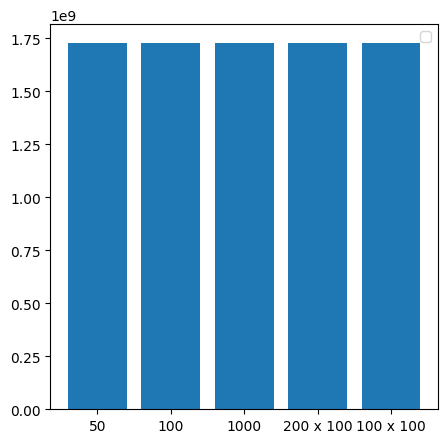

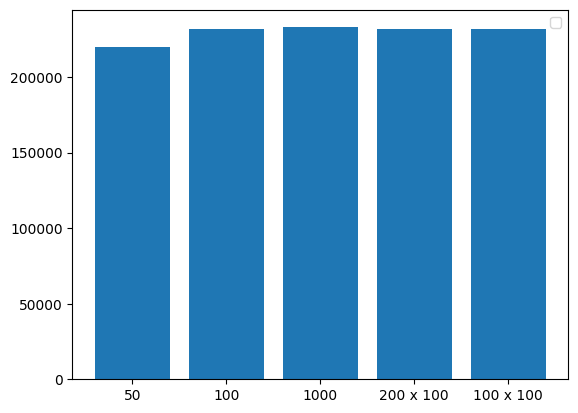

In [10]:
plt.figure(figsize=(5,5))
plt.bar(['50','100','1000', '200 x 100', '100 x 100'],exe_times)
plt.legend()
plt.show()
plt.bar(['50','100','1000', '200 x 100', '100 x 100'],errors)
plt.legend()
plt.show()

The best model has several components, including complexity, time to execute, and MSE.

#kNN

In [11]:
X_trainkNN = X_train
X_testkNN = X_test
y_trainkNN = X_trainkNN['Salary']
y_testkNN = X_testkNN['Salary']
#DROP Salary before prediction!
X_trainkNN = X_trainkNN.drop(columns = 'Salary')
X_testkNN = X_testkNN.drop(columns = 'Salary')

In [12]:
errors = []
exe_times = []
#Make a Regressor
knn=KNeighborsRegressor(n_neighbors=3)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 3 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
######################################
knn=KNeighborsRegressor(n_neighbors=5)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 5 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
######################################
knn=KNeighborsRegressor(n_neighbors=8)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 8 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
#####################################
knn=KNeighborsRegressor(n_neighbors=10)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 10 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
#####################################
knn=KNeighborsRegressor(n_neighbors=13)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 13 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
#####################################
knn=KNeighborsRegressor(n_neighbors=15)
start = time.time()
knn.fit(X_trainkNN, y_trainkNN)
knn_predict = knn.predict(X_testkNN)
end = time.time()
mse = mean_squared_error(y_testkNN,knn_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE 15 nn = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
#####################################

MSE 3 nn = 226612.5274399765
excution time: 5.0353e-02 
---------
MSE 5 nn = 227566.15725492314
excution time: 8.2417e-03 
---------
MSE 8 nn = 228116.69912404302
excution time: 7.2803e-03 
---------
MSE 10 nn = 228429.83672195766
excution time: 6.1743e-03 
---------
MSE 13 nn = 228523.45627376653
excution time: 6.0892e-03 
---------
MSE 15 nn = 228645.48127414938
excution time: 6.8102e-03 
---------


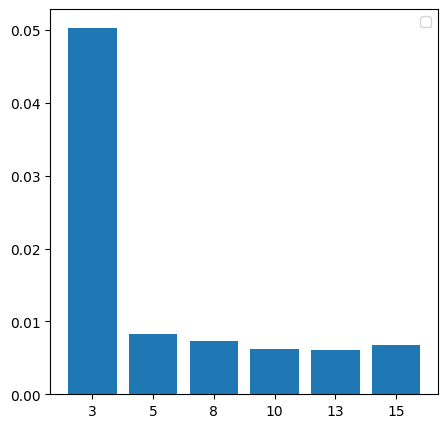

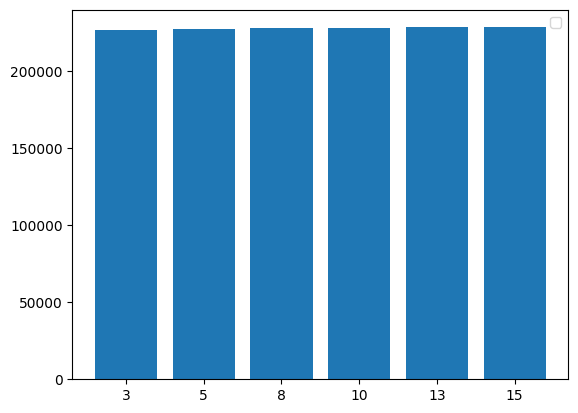

In [13]:
plt.figure(figsize=(5,5))
plt.bar(['3','5','8','10','13','15'],exe_times)
plt.legend()
plt.show()
plt.bar(['3','5','8','10','13','15'],errors)
plt.legend()
plt.show()

#Kernel Ridge Regression

In [14]:
X_trainker = X_train
X_testker = X_test
y_trainker = X_trainker['Salary']
y_testker = X_testker['Salary']
#DROP Salary before prediction!
X_trainker = X_trainker.drop(columns = 'Salary')
X_testker = X_testker.drop(columns = 'Salary')

In [15]:
coefs = []
exe_times = []
errors = []
####################################
klr = KernelRidge(alpha = 2, kernel='poly',degree=1,gamma = 1, coef0=1E-6)
start = time.time()
klr.fit(X_trainker,y_trainker)
klr_predict = klr.predict(X_testker)
end = time.time()
mse = mean_squared_error(y_testker,klr_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
coefs.append(klr.dual_coef_)
####################################
klr = KernelRidge(alpha = 2, kernel='poly',degree=2,gamma = 1, coef0=1E-6)
start = time.time()
klr.fit(X_trainker,y_trainker)
klr_predict = klr.predict(X_testker)
end = time.time()
mse = mean_squared_error(y_testker,klr_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
coefs.append(klr.dual_coef_)
####################################
klr = KernelRidge(alpha = 1, kernel='poly',degree=1,gamma = 1, coef0=1E-6)
start = time.time()
klr.fit(X_trainker,y_trainker)
klr_predict = klr.predict(X_testker)
end = time.time()
mse = mean_squared_error(y_testker,klr_predict)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
coefs.append(klr.dual_coef_)

MSE = 78627.73843933112
excution time: 1.9310e-02 
---------
MSE = 3812754042.310118
excution time: 1.1657e-02 
---------
MSE = 82372.02186983108
excution time: 2.2314e-02 
---------


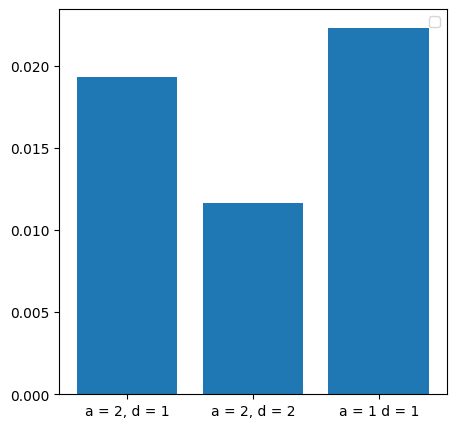

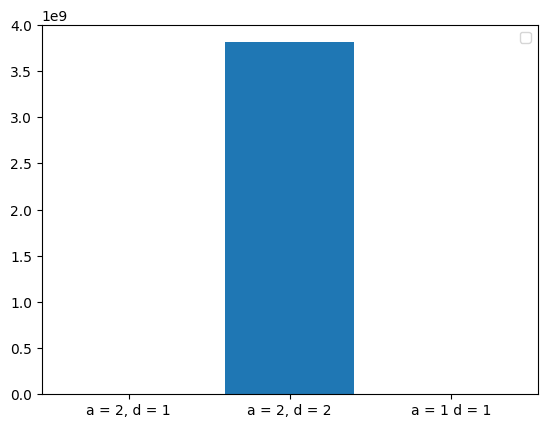

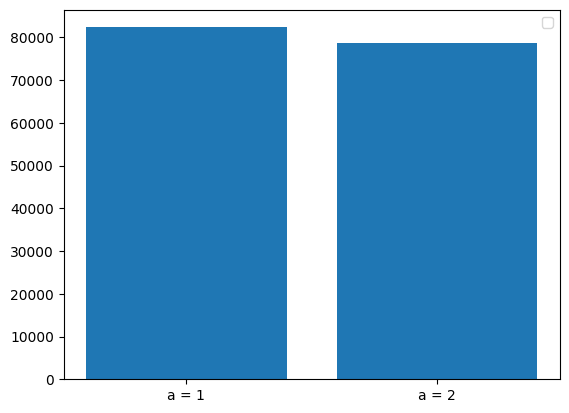

In [16]:
plt.figure(figsize=(5,5))
plt.bar(['a = 2, d = 1', 'a = 2, d = 2', 'a = 1 d = 1'],exe_times)
plt.legend()
plt.show()
plt.bar(['a = 2, d = 1', 'a = 2, d = 2', 'a = 1 d = 1'],errors)
plt.legend()
plt.show()
plt.bar(['a = 1','a = 2'],[errors[2], errors[0]])
plt.legend()
plt.show()

#SVM (Regressor)

In [27]:
#Using your provided plotting functions
def margin_cal(X):
    margin = 0.5
    xmin = min(X[:,0])-margin
    xmax = max(X[:,0])+margin
    ymin = min(X[:,1])-margin
    ymax = max(X[:,1])+margin
    return xmin, xmax, ymin, ymax

def data_plot(X, y):
    plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='red', label='y=-1')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='y=1')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    xmin, xmax, ymin, ymax = margin_cal(X)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)

def svm_plot(w,b,X,y):
    x_ = np.arange(-3,3.5,0.1)
    u = np.array([b, b+1, b-1, w[0], w[1]])#/np.linalg.norm([w1,w2])
    ##hyperplane in original space
    u_sb, u_sx = -u[0]/u[4], -u[3]/u[4]
    u_sb_u, u_sb_d = -u[1]/u[4], -u[2]/u[4]

    x2_s = x_*u_sx + u_sb
    x2_su = x_*u_sx + u_sb_u
    x2_sd = x_*u_sx + u_sb_d

    data_plot(X, y)
    plt.plot(x_, x2_s, color='green')
    plt.plot(x_, x2_su, color='green', linestyle='--')
    plt.plot(x_, x2_sd, color='green', linestyle='--')

In [28]:
X_trainSVM = X_train
X_testSVM = X_test
y_trainSVM = X_trainSVM['Salary']
y_testSVM = X_testSVM['Salary']
#DROP Salary before prediction!
X_trainSVM = X_trainSVM.drop(columns = 'Salary')
X_testSVM = X_testSVM.drop(columns = 'Salary')
errors = []
exe_times = []

In [29]:
from sklearn.svm import SVR

svm = SVR(kernel='linear', C=1E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='linear', C=2E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################

MSE = 2427072.0202950113
excution time: 1.6321e+02 
---------
MSE = 9190664.067675311
excution time: 1.3985e+02 
---------


In [30]:
svm = SVR(kernel='poly', C=1E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='poly', C=2E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################

MSE = 693548878484.7078
excution time: 4.0754e+01 
---------
MSE = 737017713173.4213
excution time: 7.6495e+01 
---------


In [31]:
svm = SVR(kernel='sigmoid', C=1E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='sigmoid', C=2E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='sigmoid', C=3E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################

MSE = 861985863284.7885
excution time: 1.2792e-02 
---------
MSE = 3446347373461.9077
excution time: 9.1057e-03 
---------
MSE = 7753084769297.953
excution time: 1.1805e-02 
---------


In [32]:
svm = SVR(kernel='rbf', C=1E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='rbf', C=2E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='rbf', C=3E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='rbf', C=4E5)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='rbf', C=1E4)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################
svm = SVR(kernel='rbf', C=1E3)
start = time.time()
svm.fit(X_trainSVM,y_trainSVM)
y_pred = svm.predict(X_testSVM)
end = time.time()
mse = mean_squared_error(y_testSVM,y_pred)
exe_times.append(end-start)
errors.append(mse)
print(f'MSE = {mse}')
print(f'excution time: {end-start:.4e} \n---------')
###############################################################

MSE = 162284.87517598848
excution time: 1.4804e+00 
---------
MSE = 174778.28588506908
excution time: 1.9218e+00 
---------
MSE = 175150.56628621576
excution time: 2.0523e+00 
---------
MSE = 173501.3366710931
excution time: 1.9442e+00 
---------
MSE = 222630.36382281958
excution time: 1.6986e-01 
---------
MSE = 230697.92813268356
excution time: 2.9490e-02 
---------


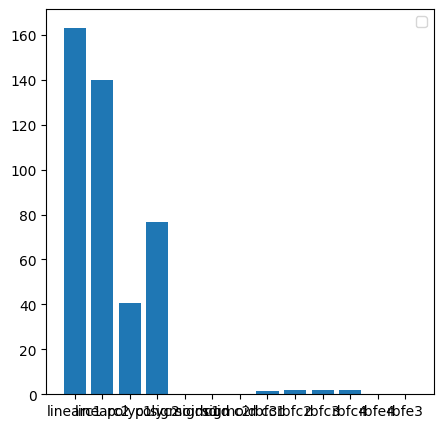

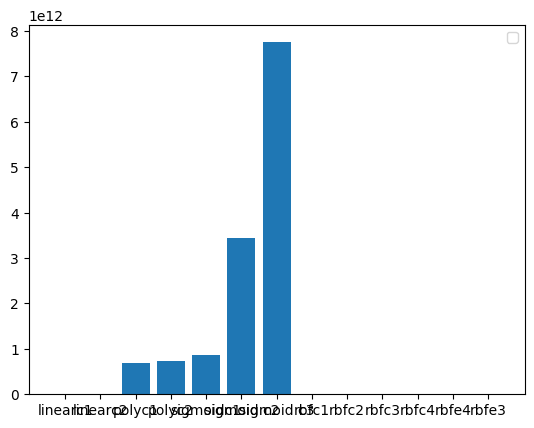

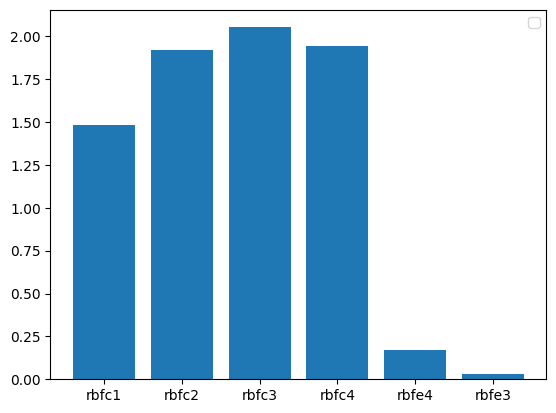

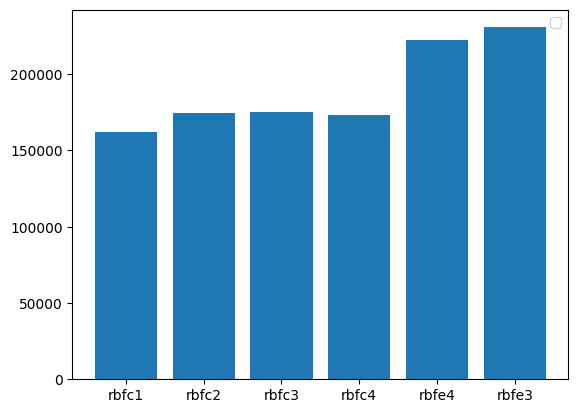

In [35]:
plt.figure(figsize=(5,5))
plt.bar(['linearc1', 'linearc2','polyc1', 'polyc2', 'sigmoidc1', 'sigmoid c2', 'sigmoid c3', 'rbfc1', 'rbfc2','rbfc3','rbfc4','rbfe4','rbfe3'],exe_times)
plt.legend()
plt.show()
plt.bar(['linearc1', 'linearc2','polyc1', 'polyc2', 'sigmoidc1', 'sigmoid c2', 'sigmoid c3', 'rbfc1', 'rbfc2','rbfc3','rbfc4','rbfe4','rbfe3'],errors)
plt.legend()
plt.show()
plt.bar(['rbfc1', 'rbfc2','rbfc3','rbfc4','rbfe4','rbfe3'],exe_times[7:])
plt.legend()
plt.show()
plt.bar(['rbfc1', 'rbfc2','rbfc3','rbfc4','rbfe4','rbfe3'],errors[7:])
plt.legend()
plt.show()
